# Wine Quality Data Mining Analysis

## Introduction

We will be analyzing data collected on wine and its quality based on 11 features of the wine along with a subjective quality ranking for the wine. The goal is to identify the wine attributes that lead to the highest (and least) perceived quality, to use K-Means cluster analysis to find three ideal pricing segments and their attribute profile, and to determine the optimal k value for K-Nearest Neighbor analysis.

Imports:

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import accuracy_score
from sklearn.neighbors import KNeighborsClassifier

## 1. Prepare the Wine Data

Convert the wine data to a DataFrame.

In [9]:
df = pd.read_csv('WineQt.csv')

df = df.drop('Id', axis=1)

df.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,5
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,5
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,6
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,5


In [10]:
df.tail()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
1138,6.3,0.510,0.13,2.3,0.076,29.0,40.0,0.99574,3.42,0.75,11.0,6
1139,6.8,0.620,0.08,1.9,0.068,28.0,38.0,0.99651,3.42,0.82,9.5,6
1140,6.2,0.600,0.08,2.0,0.090,32.0,44.0,0.99490,3.45,0.58,10.5,5
1141,5.9,0.550,0.10,2.2,0.062,39.0,51.0,0.99512,3.52,0.76,11.2,6
1142,5.9,0.645,0.12,2.0,0.075,32.0,44.0,0.99547,3.57,0.71,10.2,5


In [11]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1143 entries, 0 to 1142
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1143 non-null   float64
 1   volatile acidity      1143 non-null   float64
 2   citric acid           1143 non-null   float64
 3   residual sugar        1143 non-null   float64
 4   chlorides             1143 non-null   float64
 5   free sulfur dioxide   1143 non-null   float64
 6   total sulfur dioxide  1143 non-null   float64
 7   density               1143 non-null   float64
 8   pH                    1143 non-null   float64
 9   sulphates             1143 non-null   float64
 10  alcohol               1143 non-null   float64
 11  quality               1143 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 107.3 KB


In [14]:
np.random.seed(42)
rows = 1143

## 2. Correlation Heatmap and Top Features

We will identify the top features that impact wine quality based on correlation which we will first visualize with a heat map. Then we will graph the results for the top three and bottom four wine attributes.

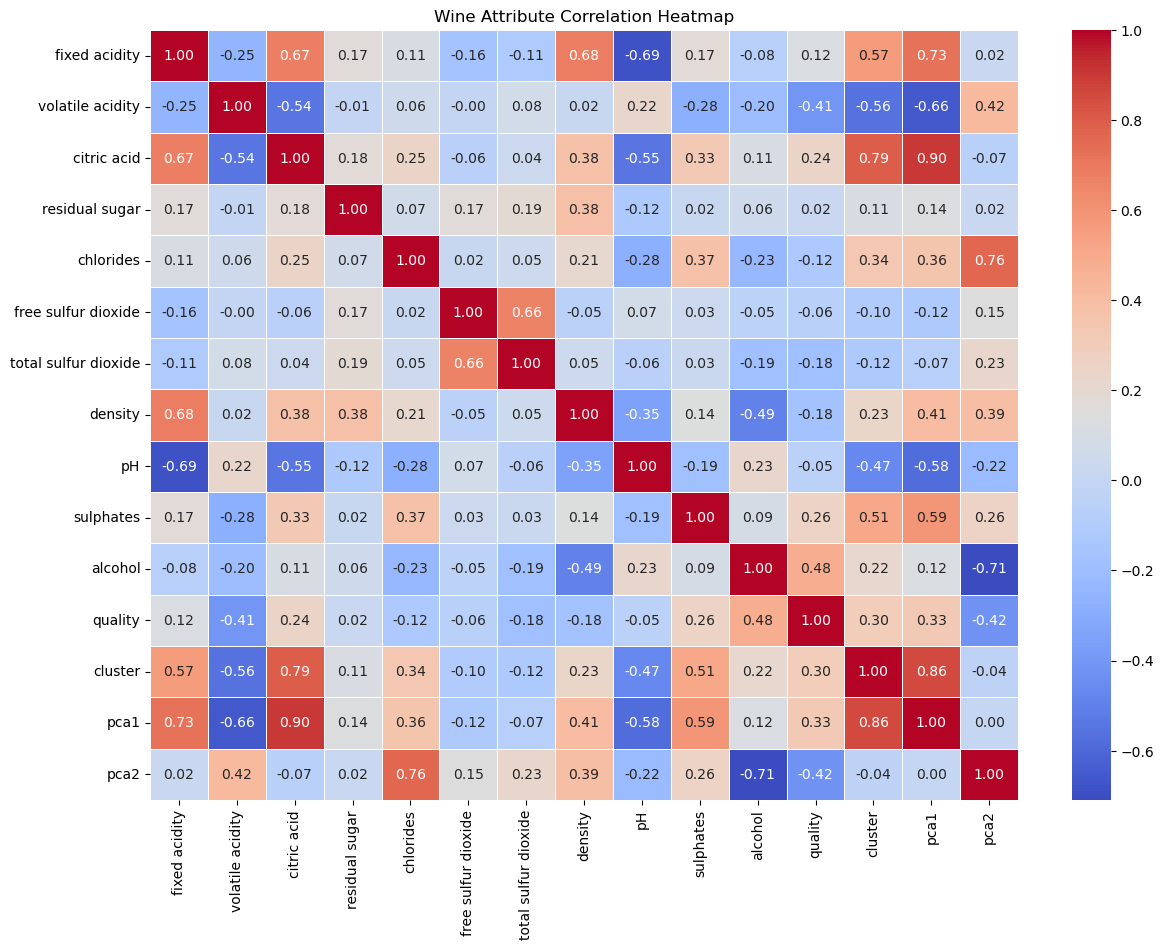

<Figure size 640x480 with 0 Axes>

In [60]:
corr_matrix = df.corr()

plt.figure(figsize=(14, 10))

sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', linewidths=0.5)

plt.title('Wine Attribute Correlation Heatmap')
plt.show()
plt.savefig('wine_heatmap.png')

In [32]:
quality_series = corr_matrix['quality'].drop('quality')

top_attributes = quality_series.abs().sort_values(ascending=False)

top_attributes

alcohol                 0.484866
volatile acidity        0.407394
sulphates               0.257710
citric acid             0.240821
total sulfur dioxide    0.183339
density                 0.175208
chlorides               0.124085
fixed acidity           0.121970
free sulfur dioxide     0.063260
pH                      0.052453
residual sugar          0.022002
Name: quality, dtype: float64

Top 3 Wine Features with Impact on Quality:
1. Alcohol
2. Volatile Acidity
3. Sulphates

We will plot the top three wine attributes and their distribution of wine quality.

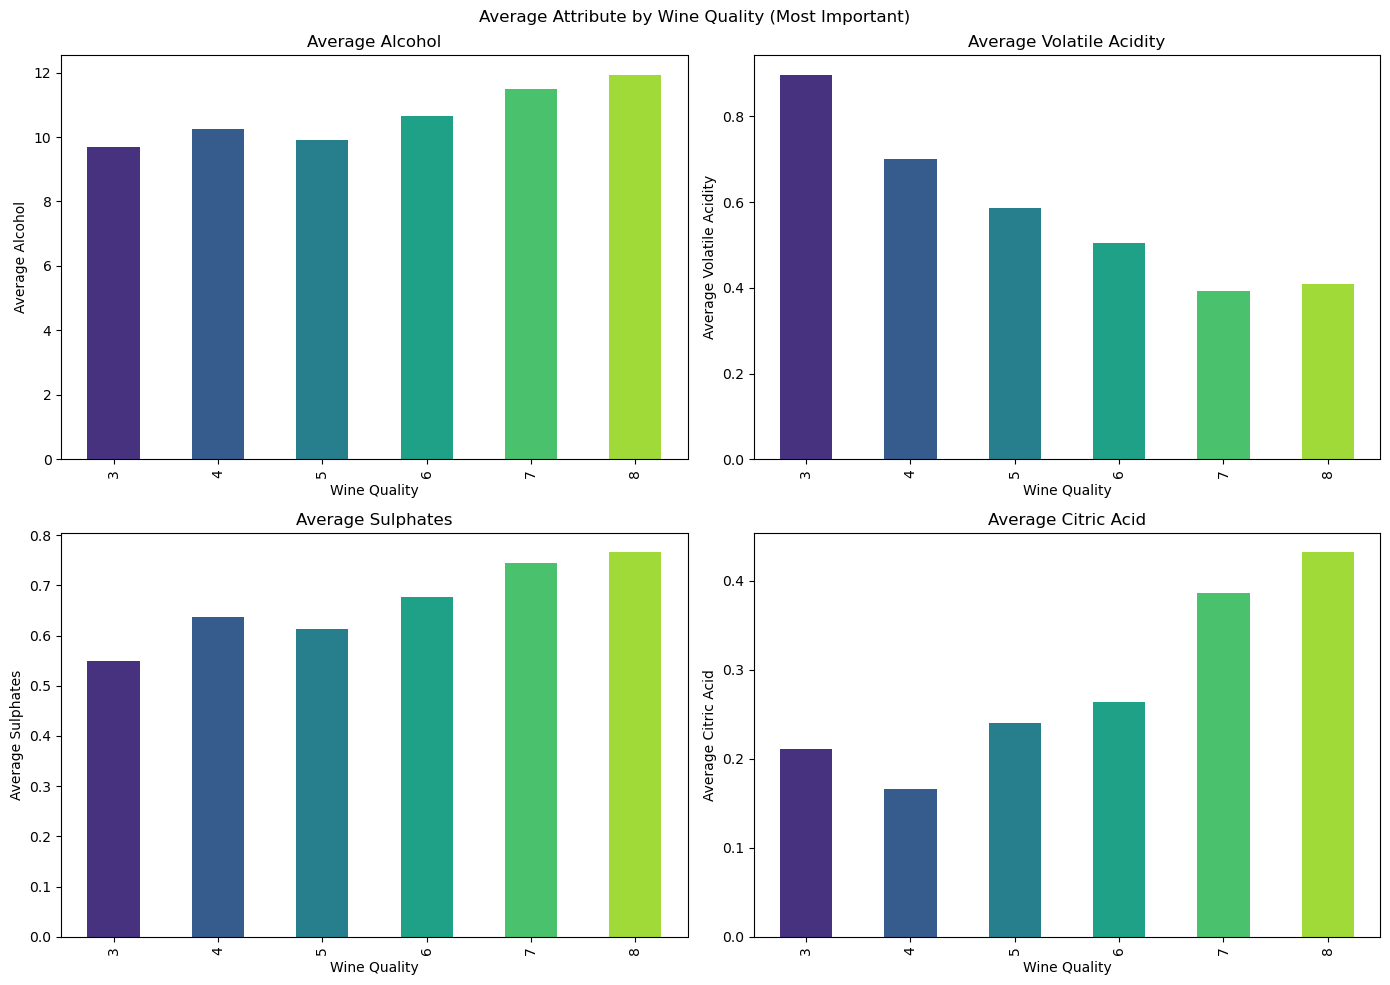

<Figure size 640x480 with 0 Axes>

In [62]:
quality_bars = top_attributes.head(4).index.tolist()

quality_groups = df.groupby('quality')[quality_bars].mean()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

fig.suptitle('Average Attribute by Wine Quality (Most Important)')

axes = axes.flatten()

for i, col in enumerate(quality_bars):
    quality_groups[col].plot(kind='bar', ax=axes[i], color=sns.color_palette('viridis', n_colors=len(quality_groups)))
    axes[i].set_title(f'Average {col.title()}')
    axes[i].set_xlabel('Wine Quality')
    axes[i].set_ylabel(f'Average {col.title()}')

plt.tight_layout()
plt.show()

plt.savefig('mostimportant_attributes.png')

Next, we will plot the four least important wine attributes and their distribution of wine quality.

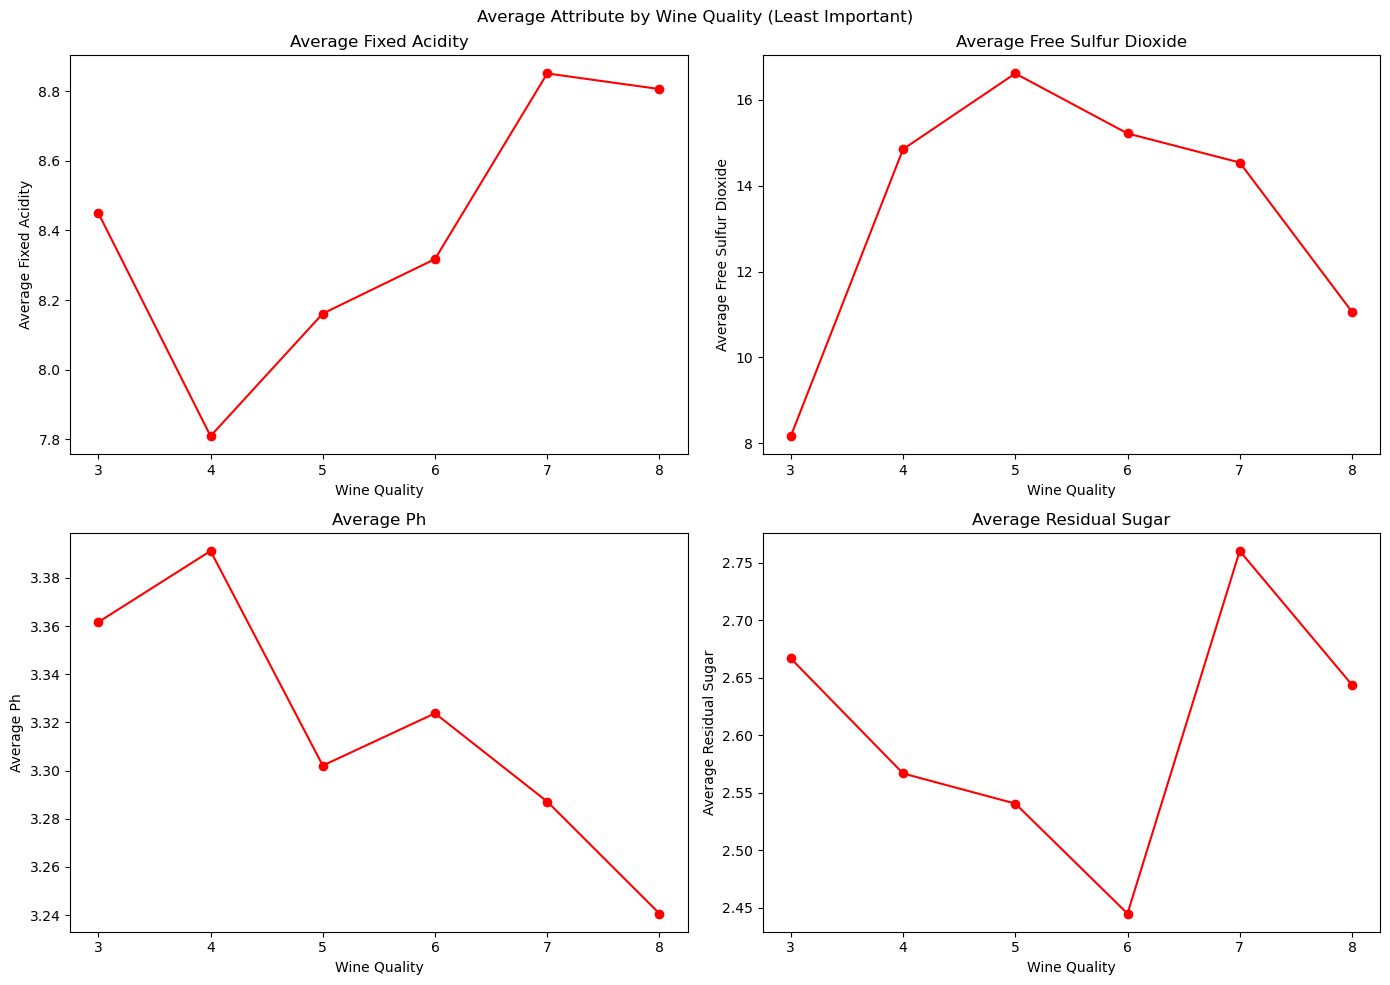

<Figure size 640x480 with 0 Axes>

In [63]:
quality_lines = top_attributes.tail(4).index.tolist()

line_groups = df.groupby('quality')[quality_lines].mean()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(14, 10))

fig.suptitle('Average Attribute by Wine Quality (Least Important)')

axes = axes.flatten()

for i, col in enumerate(quality_lines):
    line_groups[col].plot(kind='line', ax=axes[i], marker='o', color='r')
    axes[i].set_title(f'Average {col.title()}')
    axes[i].set_xlabel('Wine Quality')
    axes[i].set_ylabel(f'Average {col.title()}')

plt.tight_layout()
plt.show()

plt.savefig('leastimportant_attributes.png')

## 3. K-Means Cluster Analysis

First, prepare the data for K-Means then use the elbow method to find the optimal k value. The elbow method works by finding the point that adding another cluster does not improve the model substantially. Inerita is used to measure this.

C:\Users\ianse\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\ianse\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\ianse\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(
C:\Users\ianse\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Window

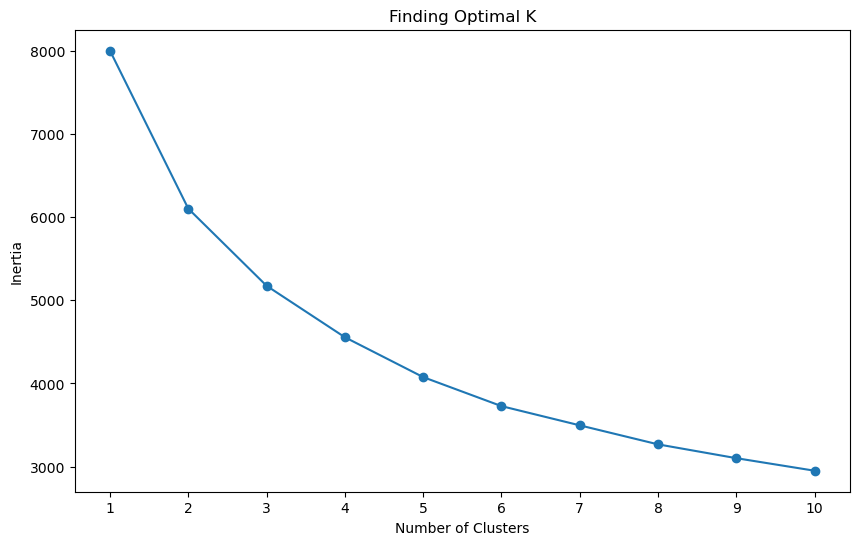

<Figure size 640x480 with 0 Axes>

In [64]:
clusters = ['alcohol', 'fixed acidity', 'volatile acidity', 'citric acid', 'chlorides', 'free sulfur dioxide', 'sulphates']
X = df[clusters]

scaler = StandardScaler()

X = scaler.fit_transform(X)

k_range = range(1, 11)

inertia = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
    kmeans.fit(X)
    inertia.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, inertia, marker='o')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.title('Finding Optimal K')
plt.xticks(k_range)
plt.show()

plt.savefig('optimal_kmean.png')

With the above graph, we can see that 3 is the optimal k value (elbow point). Using that k, we will do the k-means analysis and use principal components to plot the 4 clusters in a scatter plot.

C:\Users\ianse\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1419: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=5.
  warnings.warn(


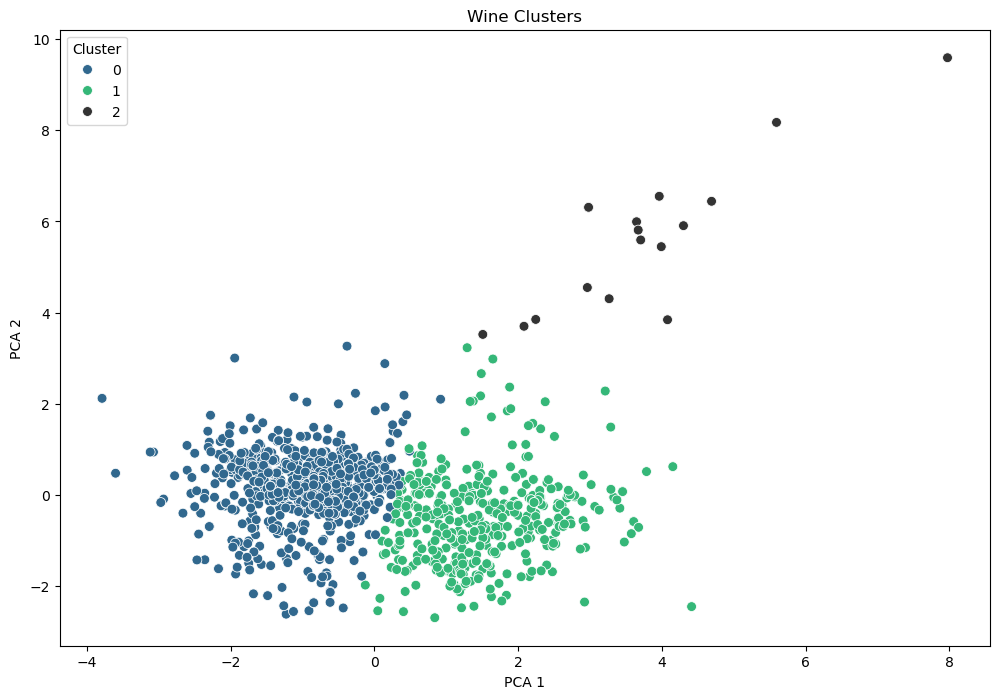

<Figure size 640x480 with 0 Axes>

In [65]:
k = 3

kmeans = KMeans(n_clusters=k, init='k-means++', random_state=42, n_init=10)
df['cluster'] = kmeans.fit_predict(X)

pca = PCA(n_components=2, random_state=42)
pca_components =  pca.fit_transform(X)

df['pca1'] = pca_components[:, 0]
df['pca2'] = pca_components[:, 1]

plt.figure(figsize=(12, 8))

sns.scatterplot(data=df, x='pca1', y='pca2', hue='cluster', palette='viridis_d', s=50)

plt.title('Wine Clusters')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')
plt.legend(title='Cluster')

plt.show()
plt.savefig('wine_clusters.png')

Next, we will group the attributes of the wines with each of the three clusters.

In [49]:
price_profiles = df.groupby('cluster')[clusters].mean()
price_profiles

,alcohol,fixed acidity,volatile acidity,citric acid,chlorides,free sulfur dioxide,sulphates
cluster,,,,,,,
0,10.216880,7.481081,0.616323,0.144452,0.080970,16.512091,0.597553
1,10.859023,9.684161,0.389728,0.461418,0.084085,14.133570,0.735863
2,9.382353,8.470588,0.540588,0.588824,0.404353,15.411765,1.200588


Then we will plot this data in graph form to visually reveal the trends with each cluster.

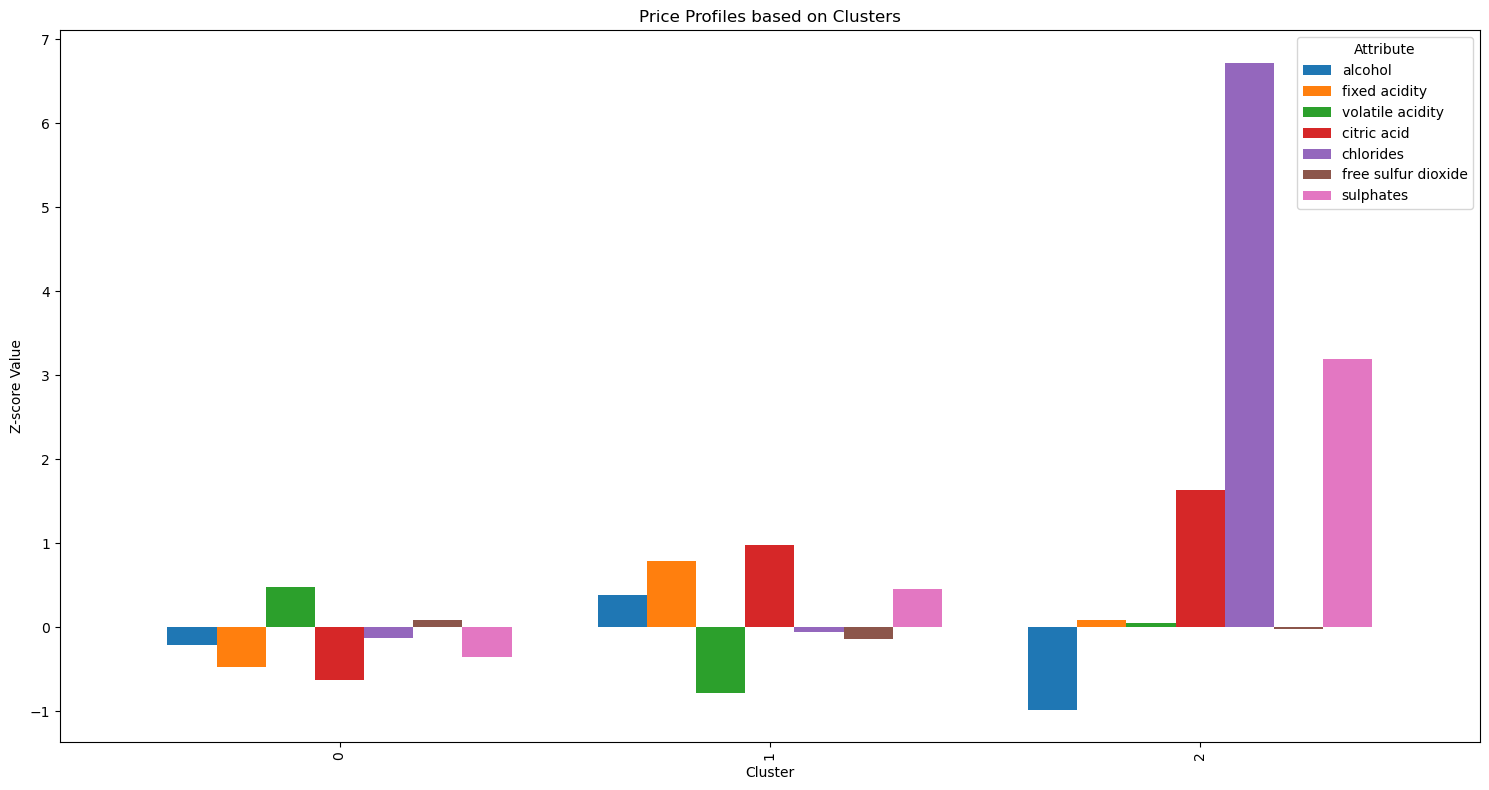

<Figure size 640x480 with 0 Axes>

In [66]:
X_df = pd.DataFrame(X, columns=clusters, index=df.index)
X_df['cluster'] = df['cluster']

grouped_profiles =  X_df.groupby('cluster').mean()

grouped_profiles.plot(kind='bar', figsize=(15, 8), width=0.8)

plt.title('Price Profiles based on Clusters')
plt.xlabel('Cluster')
plt.ylabel('Z-score Value')
plt.legend(title='Attribute')
plt.tight_layout()

plt.show()
plt.savefig('price_profiles.png')

By using K-Means clusters and grouping the values with each cluster and converting to a scaled Z-score, we can see that there are distinct traits in each cluster that can be used to determine price profiles or segments. Cluster 0 has slightly high volatile acidity, low citric acid, and low fixed acidity, but no extreme features. Cluster 1 has higher fixed acidity, citric acid, and alcohol but low volatile acidity. Cluster 2 has very high chlorides, sulphates, and citric acid, with low alcohol.

## 4. K-Nearest Neighbor Analysis

First, we will prepare the data for K-Nearest Neighbor analysis. Then we will use cross validation accuracy values to determine the optimal k value.

In [53]:
X = df.drop(['quality', 'cluster', 'pca1', 'pca2'], axis=1, errors='ignore')
y = df['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

knn_scaler = StandardScaler()

X_train = knn_scaler.fit_transform(X_train)
X_test = knn_scaler.transform(X_test)

k_range = range(1, 26)

cv_scores = []

k_fold = KFold(n_splits=10, shuffle=True, random_state=42)

for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    scores = cross_val_score(knn, X_train, y_train, cv=k_fold, scoring='accuracy')
    cv_scores.append(scores.mean())

We will plot the possible k values with their associated cross-validated accuracy.

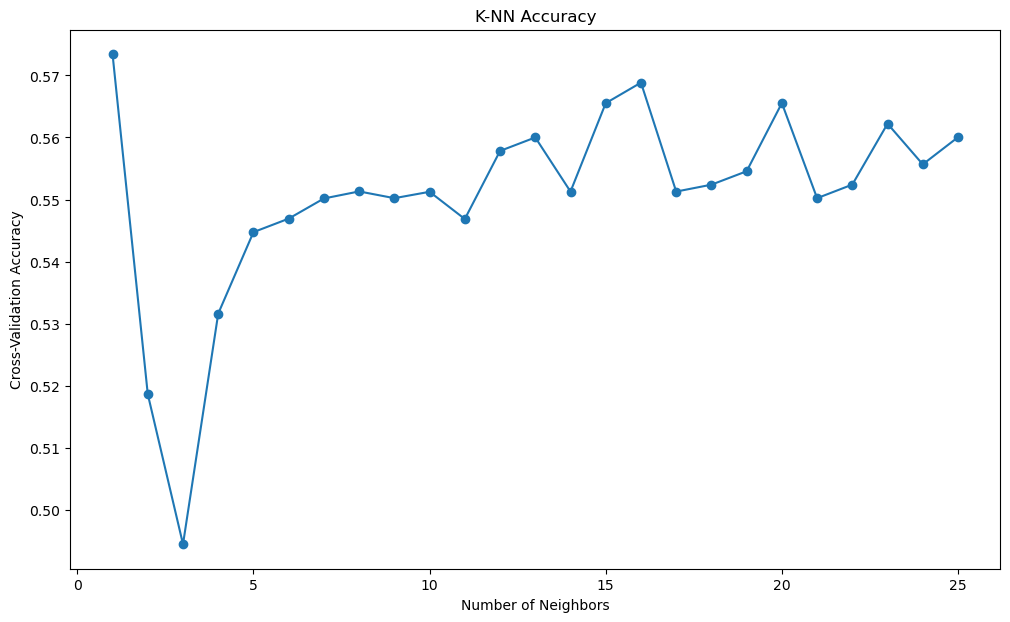

<Figure size 640x480 with 0 Axes>

In [68]:
k_range = range(1, 26)

plt.figure(figsize=(12, 7))
plt.plot(k_range, cv_scores, marker='o')
plt.xlabel('Number of Neighbors')
plt.ylabel('Cross-Validation Accuracy')
plt.title('K-NN Accuracy')

plt.show()
plt.savefig('knn_accuracy.png')

In [58]:
k = k_range[np.argmax(cv_scores)]
accuracy = np.max(cv_scores)

knn = KNeighborsClassifier(n_neighbors=k)
knn.fit(X_train, y_train)

test_accuracy = knn.score(X_test, y_test)

print(f'Optimal k = {k}')
print(f'Test accuracy = {test_accuracy}')

Optimal k = 1
Test accuracy = 0.6506550218340611


The optimal value of k is derived from finding the value in the k-range with the greatest cross-validation accuracy. For our data, the optimal k = 1 with an accuracy of approximately 0.651.